To build a model for predicting possible diagnoses from clinical notes and patient histories, using a BERT-based model (bert-base-cased), we will follow these steps:

# Steps:

Data Cleaning and Preprocessing

Tokenization

Fine-tuning BERT for Diagnosis Prediction

Evaluation (Confusion Matrix & Classification Report)

Save the Model and Implement Prediction System

# 1. Data Cleaning and Preprocessing
We will clean the text and preprocess the data to make it ready for model training.

In [1]:
import pandas as pd

data = pd.read_csv("/content/clinical_notes_diagnosis_prediction_5000.csv")
data

,Clinical Notes,Diagnosis
0,"A 35-year-old male presents with heartburn, re...",Gastroesophageal Reflux Disease
1,A 55-year-old male with a history of heavy alc...,Liver Cirrhosis
2,A 50-year-old male with a history of diabetes ...,Septic Shock
3,"A 35-year-old male presents with heartburn, re...",Gastroesophageal Reflux Disease
4,A 55-year-old female with a history of obesity...,Type 2 Diabetes Mellitus
...,...,...
4995,A 55-year-old male with a history of heavy alc...,Liver Cirrhosis
4996,"A 40-year-old female presents with swelling, p...",Deep Vein Thrombosis
4997,A 55-year-old male with a history of heavy alc...,Liver Cirrhosis
4998,"A 40-year-old female presents with swelling, p...",Deep Vein Thrombosis


In [2]:
data['Clinical Notes'][40]

'A 50-year-old male presents for a follow-up visit. He has a history of hypertension but has not been compliant with his medications. Blood pressure readings are consistently elevated at 160/100 mmHg. The patient is advised to follow a low-sodium diet and to take antihypertensive medications regularly. The patient is also referred to a cardiologist for further evaluation.'

In [3]:
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords

# Make sure to download stopwords from nltk
import nltk
nltk.download('stopwords')

# Load stopwords
stop_words = set(stopwords.words('english'))

# Extended clean_text function with more steps
def clean_text(text):
    # Convert to string and lowercase the text
    text = str(text).lower()

    # Remove any numbers (you may want to modify this if numbers are important)
    text = re.sub(r'\d+', '', text)

    # Remove special characters, punctuation, and non-alphabetical characters
    text = re.sub(r'[^a-z\s]', '', text)

    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()

    # Remove stopwords
    text = ' '.join([word for word in text.split() if word not in stop_words])

    return text

# Apply the cleaning function to the Clinical Notes column
data['Clinical Notes'] = data['Clinical Notes'].apply(clean_text)

# Show the cleaned data
data.head()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,Clinical Notes,Diagnosis
0,yearold male presents heartburn regurgitation ...,Gastroesophageal Reflux Disease
1,yearold male history heavy alcohol use present...,Liver Cirrhosis
2,yearold male history diabetes presents hypoten...,Septic Shock
3,yearold male presents heartburn regurgitation ...,Gastroesophageal Reflux Disease
4,yearold female history obesity hypertension pr...,Type 2 Diabetes Mellitus


In [4]:
data['Diagnosis'].value_counts()

,count
Diagnosis,
Peptic Ulcer Disease,284
Type 2 Diabetes Mellitus,283
Acute Myocardial Infarction,272
Chronic Obstructive Pulmonary Disease,269
Cerebrovascular Accident,263
Deep Vein Thrombosis,260
Community-Acquired Pneumonia,251
Chronic Kidney Disease,251
Septic Shock,246


In [5]:
# Label encoding for 'diagnosis' column
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
data['Diagnosis'] = label_encoder.fit_transform(data['Diagnosis'])

In [6]:
data

,Clinical Notes,Diagnosis
0,yearold male presents heartburn regurgitation ...,9
1,yearold male history heavy alcohol use present...,11
2,yearold male history diabetes presents hypoten...,16
3,yearold male presents heartburn regurgitation ...,9
4,yearold female history obesity hypertension pr...,18
...,...,...
4995,yearold male history heavy alcohol use present...,11
4996,yearold female presents swelling pain redness ...,8
4997,yearold male history heavy alcohol use present...,11
4998,yearold female presents swelling pain redness ...,8


# 2. Tokenization
For tokenization, we will use the BertTokenizer to tokenize the cleaned text.

In [7]:
from sklearn.model_selection import train_test_split
# Split data into train and test
train_texts, test_texts, train_labels, test_labels = train_test_split(data['Clinical Notes'], data['Diagnosis'], test_size=0.2)

In [8]:
# Tokenization using BERT tokenizer
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


train_encodings = tokenizer(list(train_texts), padding=True, truncation=True, max_length=512)
test_encodings = tokenizer(list(test_texts), padding=True, truncation=True, max_length=512)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [9]:
!pip install datasets

In [10]:
# Convert to Dataset format
from datasets import Dataset

train_dataset = Dataset.from_dict({'input_ids': train_encodings['input_ids'], 'attention_mask': train_encodings['attention_mask'], 'labels': train_labels.tolist()})
test_dataset = Dataset.from_dict({'input_ids': test_encodings['input_ids'], 'attention_mask': test_encodings['attention_mask'], 'labels': test_labels.tolist()})

In [11]:
train_dataset[0]

{'input_ids': [101,
  2095,
  11614,
  3287,
  7534,
  2540,
  8022,
  19723,
  12514,
  18557,
  14768,
  5510,
  2677,
  2926,
  12278,
  5776,
  2969,
  7583,
  5555,
  3436,
  2058,
  10760,
  3597,
  16671,
  2121,
  14405,
  6305,
  9821,
  8030,
  29486,
  3178,
  6887,
  8822,
  3231,
  23283,
  11616,
  16216,
  4103,
  5776,
  2318,
  4903,
  2072,
  9449,
  4468,
  9495,
  9440,
  102,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'attention_mask': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'labels': 9}

# 3. Fine-tuning BERT for Diagnosis Prediction
We will fine-tune a pre-trained BERT model for classification. Since this is a multi-class classification problem (diagnosis prediction), we will use a classification head on top of the BERT model.

In [13]:
# Load model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_encoder.classes_))

# Set training arguments with improvements
training_args = TrainingArguments(
    output_dir="./results",          # Output directory for results
    eval_strategy="epoch",     # Evaluate once per epoch - Changed from evaluation_strategy
    save_strategy="epoch",          # Save model at the end of each epoch to match evaluation strategy
    learning_rate=2e-5,              # Learning rate
    per_device_train_batch_size=16,  # Batch size for training
    per_device_eval_batch_size=16,   # Batch size for evaluation
    num_train_epochs=5,              # Increase number of epochs
    weight_decay=0.01,               # Strength of weight decay
    logging_dir="./logs",            # Directory for logging
    logging_steps=10,                # Log every 10 steps
    lr_scheduler_type="linear",      # Use linear learning rate scheduler with warmup
    warmup_steps=500,                # Number of warmup steps for learning rate scheduler
    load_best_model_at_end=True,     # Load the best model at the end of training
    metric_for_best_model="eval_loss", # Monitor eval loss to determine the best model
    save_total_limit=3,              # Limit the number of checkpoints to save
    gradient_accumulation_steps=2    # Simulate larger batch size if GPU memory is limited
)
# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

# Fine-tuning the model
trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: jagtapsuraj636 (jagtapsuraj636-isro-indian-space-research-organisation) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss
1,2.416700,2.212853
2,0.979400,0.752293
3,0.171000,0.099871
4,0.035100,0.023943
5,0.023300,0.016270


TrainOutput(global_step=625, training_loss=0.9925765544772148, metrics={'train_runtime': 511.4517, 'train_samples_per_second': 39.104, 'train_steps_per_second': 1.222, 'total_flos': 668163381600000.0, 'train_loss': 0.9925765544772148, 'epoch': 5.0})

# 4. Evaluation (Confusion Matrix & Classification Report)
After training, evaluate the model using a confusion matrix and classification report.

Classification Report:
                                       precision    recall  f1-score   support

          Acute Myocardial Infarction       1.00      1.00      1.00        58
                  Acute Renal Failure       1.00      1.00      1.00        48
                               Asthma       1.00      1.00      1.00        46
             Cerebrovascular Accident       1.00      1.00      1.00        57
               Chronic Kidney Disease       1.00      1.00      1.00        50
Chronic Obstructive Pulmonary Disease       1.00      1.00      1.00        57
         Community-Acquired Pneumonia       1.00      1.00      1.00        53
             Congestive Heart Failure       1.00      1.00      1.00        41
                 Deep Vein Thrombosis       1.00      1.00      1.00        49
      Gastroesophageal Reflux Disease       1.00      1.00      1.00        31
                         Hypertension       1.00      1.00      1.00        46
                      Liver 

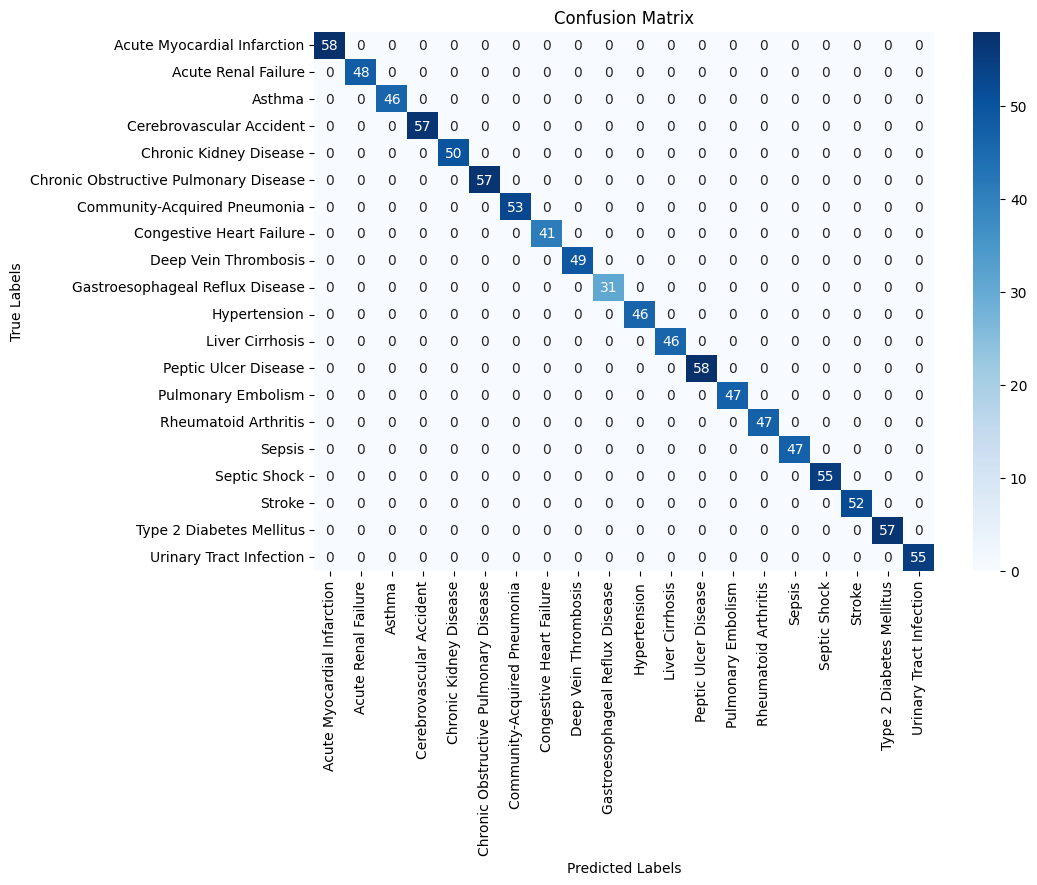

In [14]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Predictions
predictions, labels, _ = trainer.predict(test_dataset)

# Convert predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)


# Make sure the 'label_encoder.classes_' are passed as string labels
target_names = [str(label) for label in label_encoder.classes_]

# Print Classification Report
print("Classification Report:")
print(classification_report(test_labels, predicted_labels, target_names=target_names))

# Confusion Matrix
cm = confusion_matrix(test_labels, predicted_labels)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# 5. Save the Model and Implement Prediction System
Save the model and tokenizer for later use.

In [15]:
# Save the model and tokenizer
trainer.save_model('./patient_model')  # Saves the model
trainer.save_state()  # Saves the training state (e.g., optimizer state, etc.)

tokenizer.save_pretrained('./patient_model')


import pickle
pickle.dump(label_encoder,open("label_encoder.pkl",'wb'))

In [16]:
from transformers import BertForSequenceClassification, BertTokenizer
import pickle

# Load the saved model
model = BertForSequenceClassification.from_pretrained('./patient_model')

# Load the saved tokenizer
tokenizer = BertTokenizer.from_pretrained('./patient_model')

# Load the label encoder
with open("label_encoder.pkl", 'rb') as f:
    label_encoder = pickle.load(f)


In [17]:
import torch

# Function to make prediction
def predict_disease(patient_note, model, tokenizer, label_encoder):

    # Tokenize the input patient note
    inputs = tokenizer(patient_note, return_tensors="pt", padding=True, truncation=True, max_length=512)

    # Make prediction
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

    # Get the predicted label
    predicted_label = torch.argmax(logits, dim=1).item()

    # Convert the predicted label to the corresponding disease name
    predicted_disease = label_encoder.inverse_transform([predicted_label])[0]

    return predicted_disease


In [18]:
 # Example patient note (replace with actual patient notes)
patient_note = "Patient presents with fever, headache, and fatigue. Medical history includes hypertension."

# Make prediction
predicted_disease = predict_disease(patient_note, model, tokenizer, label_encoder)

# Print the prediction
print(f"Predicted Disease: {predicted_disease}")

Predicted Disease: Pulmonary Embolism


In [19]:
 # Example patient note (replace with actual patient notes)
patient_note = "'yearold male presents heartburn regurgitation sour taste mouth especially meals patient selfmedicating overthecounter antacids symptoms persist hour ph monitoring test confirms diagnosis gerd patient started ppi advised avoid trigger foods'"

# Make prediction
predicted_disease = predict_disease(patient_note, model, tokenizer, label_encoder)

# Print the prediction
print(f"Predicted Disease: {predicted_disease}")

Predicted Disease: Gastroesophageal Reflux Disease


# Download to your pc

In [20]:
import shutil
from google.colab import files

# Zip the saved model directory
shutil.make_archive('/content/patient_model', 'zip', './patient_model')

# Download the zip file
files.download('/content/patient_model.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>